# Chronicle of the Trisolarians

<img src="images/trisolarian_image1.jpeg">

This project is inspired by the science fiction "The Three Body Problem" by Liu Cixin.

The notebook is modified based on source code by Jonas Tjemsland, Andreas Krogen, Håkon Ånes and Jon Andreas Støvneng: https://nbviewer.org/urls/www.numfys.net/media/notebooks/planetary_motion_three_body_problem.ipynb#

In the novel, the Trisolarians is a civilization on a planet in an unstable three-star system. As the dynamics of 
the chaotic 4-body system evolves, the planet's climate shifts between unpredictable periods of extreme cold and 
heat -- the so-called Chaotic Era. Moreover, should the planet pass too closely by a star, it may be torn apart by 
tidal force, or worse, completely engulfed by the star. In the book, trisolarian life and civilization are born, 
destroyed, and reborn for many times, before the eventual death of the planet.

In this project, I create a simulation to output a chronicle of the trisolarian planet and its civilization (if 
there is any) given an initial condition for the unstable three-star system.

This is a midterm report of the project.

Xinran Song, 2022/02/11

## 1. Four-Body Orbit Simulation
First, we simulate the orbits of the planet and the 3 stars. Our outputs are (at all steps):

    a) Position of the four bodies.
    b) Energy of the system.
    c) Distance of each of the 3 stars to planet.

### 1.1 Imports & Settings

In [1]:
# Import libraries
import numpy as np
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
from matplotlib import animation
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import display, Image
import time
%matplotlib inline

# Set common figure parameters
newparams = {'figure.figsize': (14, 7), 'axes.grid': False,
             'lines.markersize': 6, 'lines.linewidth': 2,
             'font.size': 15, 'mathtext.fontset': 'stix',
             'font.family': 'STIXGeneral'}
plt.rcParams.update(newparams)

### 1.2 Helper functions

a) **RHS (t, y)**

Calculates the RHS of the EoM.

> Parameters:

        t: dummy parameter to be called in ode solver.
        
        y: array. Vector of length 24 holding the current position and velocity of the three objects 
           in the following manner: 
           y = [x1, y1, z1, x2, y2, z2, x3, y3, z3, x4, y4, z4,
                vx1, vy1, vz1, vx2, vy2, vz2, vx3, vy3, vz3, vx4, vy4, vz4].

> Returns:

        z: array. Vector of length 24 holding the derivative of the current position and velocity 
           (the velocity and acceleration) of the three object in the following manner:
           z = [vx1, vy1, vz1, vx2, vy2, vz2, vx3, vy3, vz3, vx4, vy4, vz4,
                ax1, ay1, az1, ax2, ay2, az2, ax3, ay3, az3, ax4, ay4, az4].


In [2]:
def RHS(t, y):

    z = np.zeros(24)
    
    z[:12] = [y[i] for i in range(12, 24)]
    
    r1, r2, r3, r4 = [y[i: i + 3] for i in range(0, 12, 3)]
    
    r21 = np.linalg.norm(r2 - r1)
    r31 = np.linalg.norm(r3 - r1)
    r41 = np.linalg.norm(r4 - r1)
    r32 = np.linalg.norm(r3 - r2)
    r42 = np.linalg.norm(r4 - r2)
    r43 = np.linalg.norm(r4 - r3)
    
    a1 = G * (m2 * (r2 - r1) / r21 ** 3 + m3 * (r3 - r1) / r31 ** 3 + m4 * (r4 - r1) / r41 ** 3)
    a2 = G * (m1 * (r1 - r2) / r21 ** 3 + m3 * (r3 - r2) / r32 ** 3 + m4 * (r4 - r2) / r42 ** 3)
    a3 = G * (m1 * (r1 - r3) / r31 ** 3 + m2 * (r2 - r3) / r32 ** 3 + m4 * (r4 - r3) / r43 ** 3)
    a4 = G * (m1 * (r1 - r4) / r41 ** 3 + m2 * (r2 - r4) / r42 ** 3 + m3 * (r3 - r4) / r43 ** 3)

    z[12:15] = a1
    z[15:18] = a2
    z[18:21] = a3
    z[21:24] = a4

    return z

b) **ode45 (f, t, y, h)**

Calculate next step of an initial value problem (IVP) of an ODE with a RHS described
    by the RHS function with an order 4 approx. and an order 5 approx.

> Parameters:

        f: function pointer. RHS of the ode.
        t: float. Current time.
        y: float. Current step (position).
        h: float. Step-length.

> Returns:

        q: float. Order 2 approx.
        w: float. Order 3 approx.

In [3]:
def ode45(f,t,y,h):
    
    s1 = f(t, y)
    s2 = f(t + h / 4.0, y + h * s1 / 4.0)
    s3 = f(t + 3.0 * h / 8.0, y + 3.0 * h * s1 / 32.0 + 9.0 * h * s2 / 32.0)
    s4 = f(t + 12.0 * h / 13.0, y + 1932.0 * h * s1 / 2197.0 - 7200.0 * h * s2 / 2197.0 + 7296.0 * h * s3 / 2197.0)
    s5 = f(t + h, y + 439.0 * h * s1 / 216.0 - 8.0 * h * s2 + 3680.0 * h * s3 / 513.0 - 845.0 * h * s4 / 4104.0)
    s6 = f(t + h / 2.0, y - 8.0 * h * s1 / 27.0 + 2 * h * s2 - 3544.0 * h * s3 / 2565 + 1859.0 * h * s4 / 4104.0 - 11.0 * h * s5 / 40.0)
    w = y + h * (25.0 * s1 / 216.0 + 1408.0 * s3 / 2565.0 + 2197.0 * s4 / 4104.0 - s5 / 5.0)
    q = y + h * (16.0 * s1 / 135.0 + 6656.0 * s3 / 12825.0 + 28561.0 * s4 / 56430.0 - 9.0 * s5 / 50.0 + 2.0 * s6 / 55.0)
    
    return w, q

c) **energy (z)**

Calculate the mechanical energies of the four body system, we use this function to verify the accuracy of numerical calculations.

> Parameters:

        z: array. Vector of length 24 holding the current position and velocity of the three objects:
           z = [vx1, vy1, vz1, vx2, vy2, vz2, vx3, vy3, vz3, vx4, vy4, vz4,
                ax1, ay1, az1, ax2, ay2, az2, ax3, ay3, az3, ax4, ay4, az4]

> Returns:

        U: float. The potential energies of the system.
        K: float. The kinetic energies of the system.

In [4]:
def energy(z):

    r1, r2, r3, r4 = [z[i: i + 3] for i in range(0, 12, 3)]
    
    # Pairwise distance between objects
    r21 = np.linalg.norm(r2 - r1)
    r31 = np.linalg.norm(r3 - r1)
    r41 = np.linalg.norm(r4 - r1)
    r32 = np.linalg.norm(r3 - r2)
    r42 = np.linalg.norm(r4 - r2)
    r43 = np.linalg.norm(r4 - r3)
    
    # Calculate potential energies
    # First object is "free", second object is moved from infinity to a distance r21 from the first object.
    # Third object is affected gravitationally by both objects.
    U1 = 0
    U2 = -G * m1 * m2 / r21
    U3 = -G * m1 * m3 / r31 - G * m3 * m2 / r32
    U4 = -G * m4 * m1 / r41 - G * m4 * m2 / r42 - G * m4 * m3 / r43
    U = U1 + U2 + U3 + U4
    
    # Calculate kinetic energies of the three objects
    K1 = 0.5 * m1 * np.linalg.norm(z[12:15]) ** 2
    K2 = 0.5 * m2 * np.linalg.norm(z[15:18]) ** 2
    K3 = 0.5 * m3 * np.linalg.norm(z[18:21]) ** 2
    K4 = 0.5 * m4 * np.linalg.norm(z[21:24]) ** 2
    K = K1 + K2 + K3 + K4
    
    return U, K

d) **distanceToStars (y)**

Calculates the distance of 3 stars to the planet.

> Parameters:

        y: array. Vector of length 24 holding the current position and velocity of the three objects:
           y = [vx1, vy1, vz1, vx2, vy2, vz2, vx3, vy3, vz3, vx4, vy4, vz4,
                ax1, ay1, az1, ax2, ay2, az2, ax3, ay3, az3, ax4, ay4, az4]

> Returns:

        r21, r31, r41: array. Distance of the first object(planet) to the other objects(stars).

In [5]:
def distanceToStars(y):

    r1, r2, r3, r4 = [y[i: i + 3] for i in range(0, 12, 3)]
    
    r21 = np.linalg.norm(r2 - r1)
    r31 = np.linalg.norm(r3 - r1)
    r41 = np.linalg.norm(r4 - r1)

    return [r21, r31, r41]

e) **traj_step**

Finally, step by step calculation of trajectory, energy, distance from stars and corresponding time.

In [6]:
def traj_step(G, m1, m2, m3, m4, T, TOL, maxi, theta, z0):

    # First step and initial time
    h = T / maxi
    t = 0.

    # Allocate matrices and fill with initial conditions
    Z = np.zeros((24, maxi + 1))
    Z[:, 0] = z0
    Z_t = np.zeros((25, maxi + 1))
    Z_t[-1, 0] = 0
    Z_t[:-1, 0] = z0
    E = np.zeros((maxi + 1, 2))
    E[0, :] = energy(z0)
    D = np.zeros((maxi + 1, 3))
    D[0, :] = distanceToStars(z0)

    # Declare iteration integer
    i = 0
    e = 1.
    # Perform ode45 calculations
    tic = time.time()
    while (t < T) & (i < maxi):
        w, q = ode45(RHS, t, Z[:, i], h)
        e = max(abs((w - q) / np.maximum(w, theta)))
        if e > TOL:
            h = 0.95 * (TOL * e) ** (1 / 5) * h 
            w, q = ode45(RHS, t, q, h)
            e = max(abs((w - q) / np.maximum(w, theta)))
            while e > TOL:
                h = h/2.
                w, q = ode45(RHS, t, q, h)
                e = max(abs((w - q) / np.maximum(w, theta)))
        if e < 0.1 * TOL:
            h = h * 2.
        Z[:, i + 1] = q
        Z_t[-1, i + 1] = t + h
        Z_t[:-1, i + 1] = q
        E[i + 1, :] = energy(Z[:, i + 1])
        D[i + 1, :] = distanceToStars(Z[:, i + 1])
        t += h
        i += 1

    print("%.5f s, run time of adaptive RK45 method." % (time.time() - tic))
        
    # Print number of steps used
    if (i == maxi):
        print('%i, maximum number of steps reached by adaptive RK45 method.' % i)
    else:
        print('%i, steps used by adaptive RK45 method.' % i)

    t_out = Z_t[-1, :i]

    return Z_t[:-1, :i], E[:i, :], D[:i, :], t_out

**Extrapolate trajectories by step to trajectories by at time intervals (NOT WORKING).**

In [ ]:
from scipy.interpolate import interp1d

def traj_time(Z_t, i, T, dt):
    t = Z_t[0, :i]
    vals = Z_t[1:, :i]
    f_z = interp1d(t, vals, kind='previous', fill_value='extrapolate')
    t_new = np.linspace(0, dt, T)
    vals_new = f_z(t_new)
    f_d = interp1d(t, np.transpose(D[:i, :]), kind='nearest', fill_value='extrapolate')
    D_new = f_d(t_new)
    return vals_new, D_new

### 1.3 Plotting

Plot 3D trajectory, Energy by step, and Distance to 3 stars by time.

In [7]:
def plot(Z, E, D, t, plot_planet):
    plt.figure()

    # Trajectory
    ax = plt.axes(projection="3d")

    if plot_planet:
        plt.plot(Z[0, :], Z[1, :], Z[2, :], '-r', label='m1')
        ax.scatter3D(Z[0, 0], Z[1, 0], Z[2, 0], marker='*', color='red', label='Init pos m1')
        
    plt.plot(Z[3, :], Z[4, :], Z[5, :], '-b', label='m2')
    plt.plot(Z[6, :], Z[7, :], Z[8, :], '-g', label='m3')
    plt.plot(Z[9, :], Z[10, :], Z[11, :], color='black', label='m4')
    ax.scatter3D(Z[3, 0], Z[4, 0], Z[5, 0], marker='*', color='blue', label='Init pos m2')
    ax.scatter3D(Z[6, 0], Z[7, 0], Z[8, 0], marker='*', color='green', label='Init pos m3')
    ax.scatter3D(Z[9, 0], Z[10, 0], Z[11, 0], marker='*', color='black', label='Init pos m4')
    plt.xlabel('x (m)')
    plt.ylabel('y (m)')
    plt.legend(loc='best', prop={'size': 10})
    plt.title('Trajectories')
    plt.show()

    # Mechanical energy
    plt.subplot(2, 2, 3)
    plt.plot(E[:, 0], 'g', label='K')
    plt.plot(E[:, 1], 'b', label='U')
    plt.plot(E[:, 0] + E[: ,1], 'm', label='Total energy E')
    plt.xlabel('Steps, i')
    plt.ylabel('E')
    plt.legend(loc='best', prop={'size': 10})
    plt.title('Energy and absolute angular momentum')

    # Distance from Stars
    plt.subplot(2, 2, 4)
    plt.plot(t, D[:, 0], 'b', label='m2')
    plt.plot(t, D[:, 1], 'g', label='m3')
    plt.plot(t, D[:, 2], 'r', label='m4')
    plt.xlabel('Time (yrs)')
    plt.ylabel('Distance (m)')
    plt.legend(loc='best', prop={'size': 10})
    plt.title('Distance of m1 from others')
    
    plt.show()

### 1.4 Animation

a) 2D Animation of trajectory in x-y plane

In [8]:
def animation_2d(Z, T, maxi, name):
    # Set up the figure
    fig = plt.figure()
    ax = plt.axes(xlim=(np.min(Z[[0,3,6,9],:]), np.max(Z[[0,3,6,9],:])), 
                ylim=(np.min(Z[[1,4,7,10],:]), np.max(Z[[1,4,7,10],:])))
    ax.set_aspect('equal')

    # Define the different elements in the animation
    tail1, = ax.plot([],[],'r') # Tail obj. 1
    tail2, = ax.plot([],[],'b') # Tail obj. 2
    tail3, = ax.plot([],[],'g') # Tail obj. 3
    tail4, = ax.plot([],[],color='black') # Tail obj. 4
    obj1, = ax.plot([],[],'ro') # Obj. 1
    obj2, = ax.plot([],[],'bo') # Obj. 2
    obj3, = ax.plot([],[],'go') # Obj. 3
    obj4, = ax.plot([],[],color='black') # Obj. 4

    # Calculates the number of frames
    FPS = 15
    framesNum = int(FPS*T)

    # Animation function. This is called sequentially.
    def animate(j):
        i = j*int(maxi / framesNum)
        obj1.set_data(Z[0,i],Z[1,i])
        obj2.set_data(Z[3,i],Z[4,i])
        obj3.set_data(Z[6,i],Z[7,i])
        obj4.set_data(Z[9,i],Z[10,i])
        tail1.set_data(Z[0,0:i],Z[1,0:i])
        tail2.set_data(Z[3,0:i],Z[4,0:i])
        tail3.set_data(Z[6,0:i],Z[7,0:i])
        tail4.set_data(Z[9,0:i],Z[10,0:i])

    # Create animation
    anim = animation.FuncAnimation(fig, animate, frames=framesNum)

    # Save animation
    # If this don't work for you, try using the another writer (ffmpeg, mencoder, imagemagick),
    # or another file extension (.mp4, .gif, .ogg, .ogv, .avi etc.). Make sure that you have
    # the codec and the writer installed on your system.
    anim.save(name, writer='imagemagick', fps=FPS)

    # Close plot
    plt.close(anim._fig)

    # Display the animation
    with open('2D.gif','rb') as file:
        display(Image(file.read()))


b) 3D Animation

In [ ]:
def animation_3d(Z, T, maxi):
    
    # ANIMATION FUNCTION
    def func(n, dataSet, obj1, obj2, obj3, obj4):
        i = n * int(maxi /framesNum)
        obj1.set_data(dataSet[0:2, :i])
        obj1.set_3d_properties(dataSet[2, :i])
        obj2.set_data(dataSet[3:5, :i])
        obj2.set_3d_properties(dataSet[5, :i])
        obj3.set_data(dataSet[6:8, :i])
        obj3.set_3d_properties(dataSet[8, :i])
        obj4.set_data(dataSet[9:11, :i])
        obj4.set_3d_properties(dataSet[11, :i])

    # GET SOME MATPLOTLIB OBJECTS
    fig = plt.figure()
    ax = Axes3D(fig)

    # set objects
    obj1 = plt.plot(Z[0], Z[1], Z[2], lw=2, c='r')[0]
    obj2 = plt.plot(Z[3], Z[4], Z[5], lw=2, c='b')[0]
    obj3 = plt.plot(Z[3], Z[4], Z[5], lw=2, c='g')[0]
    obj4 = plt.plot(Z[3], Z[4], Z[5], lw=2, c='black')[0]

    ax.set_xlim3d([np.min(Z[[0,3,6,9],:]), np.max(Z[[0,3,6,9],:])])
    ax.set_ylim3d([np.min(Z[[1,4,7,10],:]), np.max(Z[[1,4,7,10],:])])
    ax.set_zlim3d([np.min(Z[[2,5,8,11],:]), np.max(Z[[2,5,8,11],:])])
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title('Trajectories')
    
    # Creating the Animation object
    FPS = 15
    framesNum = int(FPS*T)
    line_ani = animation.FuncAnimation(fig, func, frames=framesNum, fargs=(Z,obj1,obj2,obj3,obj4), interval=50, blit=False)
    line_ani.save('trial.gif', writer='imagemagick', fps=FPS)
    
    plt.show()

c) Build a general grapher.

In [9]:
def grapher(Z, E, D, t, graph=True, animate2d=False, animate3d=False):
    if graph:
        plot(Z, E, D, t, plot_planet=True)
    if animate2d:
        animation_2d(Z, E, D, Z.shape[1], maxi)
    if animate3d:
        animation_3d(Z, E, D, Z.shape[1], maxi)

We can store some interesting initial conditions in a dictionary.

The first two conditions are from classic 3-body problem solutions, the units for the constants are defined for convenience of long-time-range simulation, more on this later!

The last condition is in SI units, for our own solar system.

### 1.5 Verification with solar system constants

First store the initial conditions for our solar system (Sun, Earth, Mar, Jupiter).

In [ ]:
init_conditions = {}

# solar system: m1=Earth, m2=Sun, m3=Mars, m4=Jupiter
r1 = [1.5e11, 0., 0.]
r2 = [0, 0, 0]
r3 = [1.37e11, 0., 0.]
r4 = [4.63e11, 0, 0]
v1 = [0., 2.978e4, 0.]
v2 = [0., 0., 0.]
v3 = [0, 2.407e4, 0]
v4 = [0., 1.3e4, 0.]
z0 = np.array(r1 + r2 + r3 + r4 + v1 + v2 + v3 + v4)
init_conditions["solarsys"] = z0

Let's try simulating for time range of 1 year, even this will take quite a while!

55.56140 s, run time of adaptive RK45 method.
9224, steps used by adaptive RK45 method.


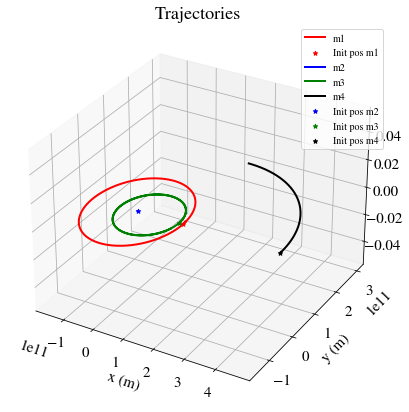

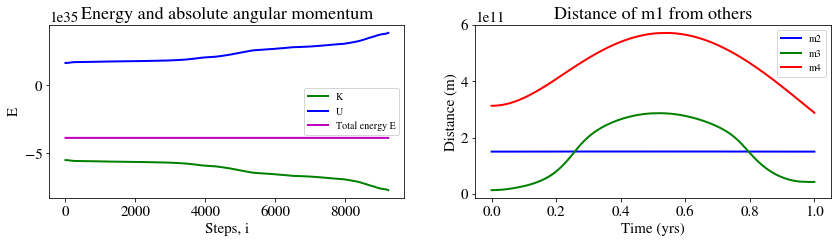

In [23]:
# Solar system for 1 year: m1 = Earth, m2 = Sun, m3 = Mars, m4 = Jupiter

z0 = init_conditions['solarsys']

G = 6.674e-11
m1 = 5.972e24
m2 = 1.989e30
m3 = 6.39e23
m4 = 1.898e27

# Period of calculations of 1 year
T = 3.154e7 * 1
# Tolerance
TOL = 0.00001
# Maximum number of steps
maxi = 10000
# "Protector-constant" for small w
theta = 0.001

Z_earth, E_earth, D_earth, t_earth = traj_step(G, m1, m2, m3, m4, T, TOL, maxi, theta, z0)
t_earth /= 3.154e7

# Graphing
grapher(Z_earth, E_earth, D_earth, t_earth)

### 1.6 Simple Atmospheric Model for Planet Temperature

Now we write a (very rough) model to calculate the planet's temperature given it's distance from the stars.

In [10]:
# Returns Temperature in celsius against time

def temperature(D, P_star):

    sigma = 5.67e-8 # stefan-boltzmann constant

    # Assume trisolarian planet has the same albedo as Earth
    alb = 0.3

    T = []
    for j in range(D.shape[0]):
        d = D[j, :]
        solar_const = np.dot((d ** (-2)), P_star) / 4 / np.pi
        # print(solar_const)
        total_I = (1 - alb) * solar_const / 4
        temp = (total_I / sigma) ** 0.25 - 273.15
        T.append(temp)

    return np.array(T)

In [11]:
# Graphing temperature
def graph_temperature(t, T):
    plt.title('Temperature of figure-8-z planet')
    plt.xlabel('Time (yrs)')
    plt.ylabel('Temperature (C)')
    plt.plot(t, T)

Let's verify this model using the Earth-Sun system, we expect an average of -18 celsius (as I said, very rough model...)

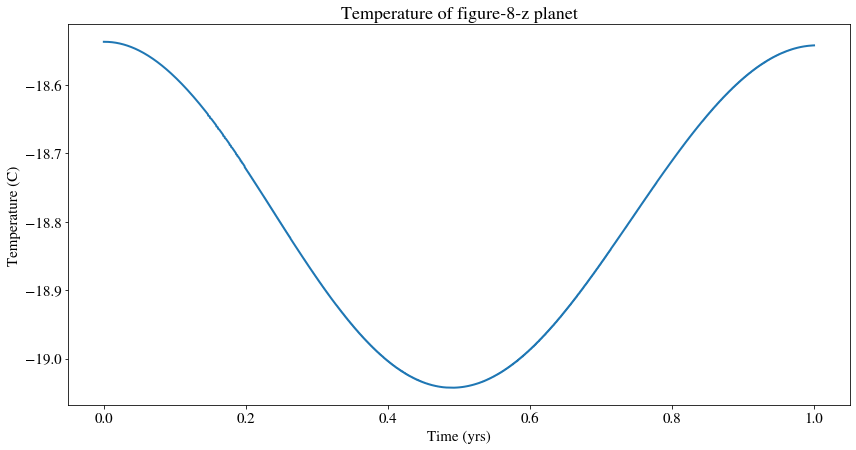

In [24]:
P_star = [3.85e26, 0., 0.] # sun, planet, planet
T_earth = temperature(D_earth, P_star)
graph_temperature(t_earth, T_earth)

### 1.7 Some "stable" trisolarian systems for more years!

To be able to simulate for longer times, we find that these particular initial conditions of figure-8 trisolarian stars work particularly well -- but we don't know there units in SI!

In [ ]:
# figure8 with coplanar planet
v = [-0.93240737, -0.86473146, 0]
r1 = [-0.33, -0.3, 0.]
r2 = [0.97000436, -0.24308753, 0.]
r3 = [-0.97000436, 0.24308753, 0.]
r4 = [0., 0., 0.]
v1 = [0., 0., 0.]
v2 = [-0.93240737 * (-0.5), -0.86473146 * (-0.5), 0]
v3 = v2
v4 = v
z0 = np.array(r1 + r2 + r3 + r4 + v1 + v2 + v3 + v4)
init_conditions["fig8-planet"] = z0

# figure8 with planet out of plane
v = [-0.93240737, -0.86473146, 0]
r1 = [0., 0., 0.1]
r2 = [0.97000436, -0.24308753, 0.]
r3 = [-0.97000436, 0.24308753, 0.]
r4 = [0., 0., 0.]
v1 = [0., 0., 0.]
v2 = [-0.93240737 * (-0.5), -0.86473146 * (-0.5), 0]
v3 = v2
v4 = v
z0 = np.array(r1 + r2 + r3 + r4 + v1 + v2 + v3 + v4)
init_conditions["fig8-planet-z"] = z0

We can reverse engineer the units of these constants.

Let the units of time, length, and mass of the constants be $T', L', M'$, where $T' = \tau (s), L' = \gamma (m), M' = \mu (kg)$

The gravitational constant $$G' = \gamma^3 \mu^{-1} \tau^{-2} m^3 kg^{-1} s^{-2}= 6.674 * 10^{-11} kg^{-1} s^{-2}$$

$$\gamma^3 \mu^{-1} \tau^{-2} = 6.674 * 10^{-11}$$

The mass of a star is around $10^{30}$ kg, hence $$\mu = 10^{30}$$

$$\gamma^3 \tau^{-2} = 6.674 * 10^{19}$$

Let $\tau = 100 yrs = 3.154 * 10^9 s$, we have $\gamma = (6.674 * 10^{19} * (3.154* 10^9)^2)^{\frac{1}{3}} = 8.724 * 10^{12}$

Therefore:

In [ ]:
mu = 10 ** 30
tau = 3.154e9 # 100 years
gamma = 8.724e12

With these unit scaling, let's tryout a few initial conditions.

In [ ]:
# General constants

# Gravitational constant
G = 1.

# Planet and star masses
m1 = 0.001  # m1 is planet
m2 = 1.
m3 = 1.
m4 = 1.

# Period of calculations
T = 100
# Tolerance
TOL = 0.00001
# Maximum number of steps
maxi = 10000
# "Protector-constant" for small w
theta = 0.001

**First we look at a planet in the same plane as the figure-8 stars.**

In [ ]:
z0 = init_conditions['fig8-planet']
Z, E, D, t1 = traj_step(G, m1, m2, m3, m4, T, TOL, maxi, theta, z0)

# Unit translation
t1 *= 100 # in years
Z *= gamma
D *= gamma
E *= mu * gamma ** 2 * tau ** (-2)

# Trajectory Graph
grapher(Z, E, D, t1)

# Temperature graph
P_star = [3.85e26, 3.85e26, 3.85e26] # assume all 3 stars has same power as our Sun
Temp1 = temperature(D, P_star)
graph_temperature(t1, Temp1)

**Then we shift the planet slightly out of plane**

Note here the resulting time is only 300 years instead of 10000, this is because with more variations in movements, the calculations take more steps and exceeded the limit early.

In [ ]:
z0 = init_conditions['fig8-planet-z']
Z, E, D, t2 = traj_step(G, m1, m2, m3, m4, T, TOL, maxi, theta, z0)

# Unit translation
t2 *= 100 # in years
Z *= gamma
D *= gamma
E *= mu * gamma ** 2 * tau ** (-2)

# Trajectory Graph
grapher(Z, E, D, t2)

# Temperature graph
P_star = [3.85e26, 3.85e26, 3.85e26] # assume all 3 stars has same power as our Sun
Temp2 = temperature(D, P_star)
    
graph_temperature(t2, Temp2)

### 1.8 Survival Report

In [12]:
def habitable_intervals(t, temp, lo, hi):

    def is_good(T):
        return T > lo and T < hi

    intervals = []
    i = 0
    l = 0
    r = 0
    good = False
    while i < len(temp):
        if not good:
            if is_good(temp[i]):
                l = i
                good = True
        else:
            if not is_good(temp[i]):
                r = i - 1
                intervals.append((t[l], t[r]))
                good = False
            else:
                if i == len(temp) - 1:
                    r = i
                    intervals.append((t[l], t[r]))
        i += 1
    
    return intervals
    

In [13]:
def report(t, temp, lo, hi):
    intervals = habitable_intervals(t, temp, lo, hi)
    intervals = [tup for tup in intervals if tup[1] - tup[0] >= 1]
    if not intervals:
        print('There is no habitable period in the next', int(t[-1]), 'years.')
        return
    print('Trisolarian Observatory reports', len(intervals), 'habitable period in the next', int(t[-1]), 'years:')
    print('Begin', ' ', 'End', ' ', 'Duration')
    stable_eras = []
    for tup in intervals:
        l, r = tup
        if r - l >= 10:
            stable_eras.append(tup)
        if r - l >= 1:
            print(int(l), '    ', int(r), '    ', int(r - l))
    if not stable_eras:
        print('There is no Stable Era in the next', int(t[-1]), 'years.')
        return
    print('There are', len(stable_eras), 'upcoming Stable Eras:')
    print('Begin', '    ', 'End', '    ', 'Duration')
    for tup in stable_eras:
        l, r = tup
        print(int(l), '    ', int(r), '    ', int(r - l))

### 1.9 Overall Workflow

Log and name initial conditions to test.

In [14]:
init_conditions = {}

# figure8 with coplanar planet
v = [-0.93240737, -0.86473146, 0]
r1 = [-0.33, -0.3, 0.]
r2 = [0.97000436, -0.24308753, 0.]
r3 = [-0.97000436, 0.24308753, 0.]
r4 = [0., 0., 0.]
v1 = [0., 0., 0.]
v2 = [-0.93240737 * (-0.5), -0.86473146 * (-0.5), 0]
v3 = v2
v4 = v
z0 = np.array(r1 + r2 + r3 + r4 + v1 + v2 + v3 + v4)
init_conditions["fig8-planet"] = z0

# figure8 with planet out of plane
v = [-0.93240737, -0.86473146, 0]
r1 = [0., 0., 0.1]
r2 = [0.97000436, -0.24308753, 0.]
r3 = [-0.97000436, 0.24308753, 0.]
r4 = [0., 0., 0.]
v1 = [0., 0., 0.]
v2 = [-0.93240737 * (-0.5), -0.86473146 * (-0.5), 0]
v3 = v2
v4 = v
z0 = np.array(r1 + r2 + r3 + r4 + v1 + v2 + v3 + v4)
init_conditions["fig8-planet-z"] = z0

### YOUR CONDITIONS HERE ###
r1 = [0.1, 0., 0.] # something between [-0.1, 0.1], cannot all be zero
v1 = [0.1, 0., 0.] # something between [-0.1, 0.1]

v = [-0.93240737, -0.86473146, 0]
r2 = [0.97000436, -0.24308753, 0.]
r3 = [-0.97000436, 0.24308753, 0.]
r4 = [0., 0., 0.]
v2 = [-0.93240737 * (-0.5), -0.86473146 * (-0.5), 0]
v3 = v2
v4 = v
z0 = np.array(r1 + r2 + r3 + r4 + v1 + v2 + v3 + v4)
init_conditions["narnix"] = z0


Set parameters.

In [15]:
# Gravitational constant
G = 1.

# Planet and star masses
m1 = 0.001  # m1 is planet
m2 = 1.
m3 = 1.
m4 = 1.

# Initial conditions
z0 = init_conditions['narnix']

# Power of stars
P_star = [3.85e26, 3.85e26, 3.85e26] # assume all 3 stars has same power as our Sun

# Survival temperature range
T_low = -200
T_high = 200

# Period of calculations
T = 100     # 10000 yrs
# Tolerance
TOL = 0.00001
# Maximum number of steps
maxi = 10000     # <30s calculation time
# "Protector-constant" for small w
theta = 0.001

# Unit Translations
mu = 10 ** 30
tau = 3.154e9   # 100 years
gamma = 8.724e12

Calculate trajectory, energy, distances and temperature.

In [16]:
Z, E, D, t = traj_step(G, m1, m2, m3, m4, T, TOL, maxi, theta, z0)

t *= 100 # in years
Z *= gamma
D *= gamma
E *= mu * gamma ** 2 * tau ** (-2)

T = temperature(D, P_star)

32.33008 s, run time of adaptive RK45 method.
10000, maximum number of steps reached by adaptive RK45 method.


Graph as needed.

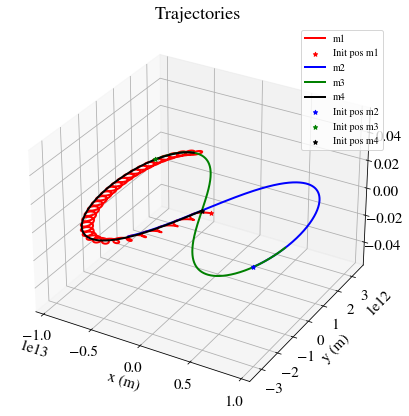

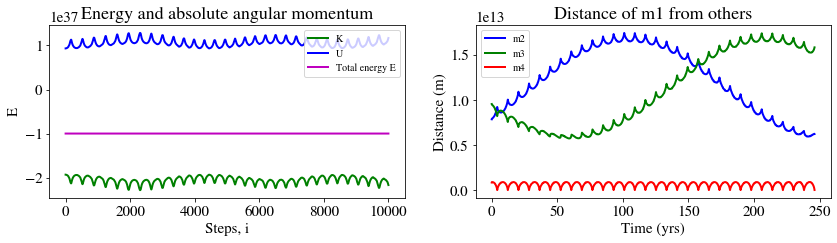

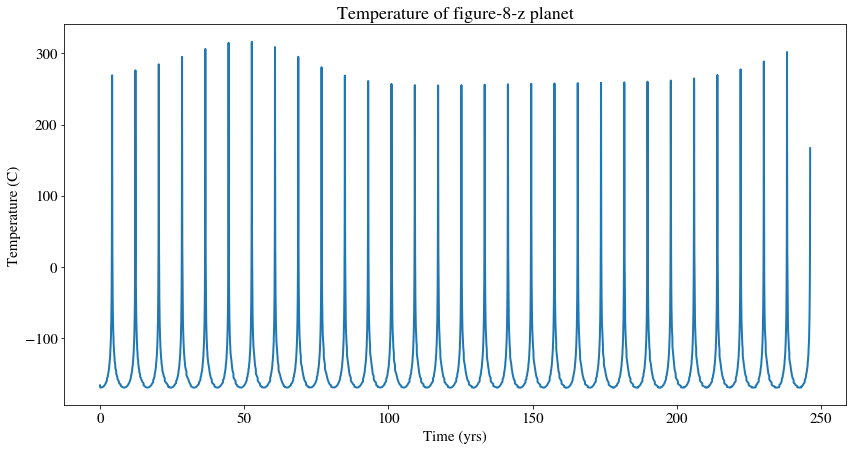

In [17]:
grapher(Z, E, D, t)
graph_temperature(t, T)

Report as needed.

In [18]:
report(t, T, T_low, T_high)

Trisolarian Observatory reports 31 habitable period in the next 246 years:
Begin   End   Duration
0      4      4
4      12      8
12      20      8
20      28      8
28      36      8
36      44      8
44      52      8
52      60      7
60      68      8
68      76      8
76      84      8
84      92      8
92      101      8
101      109      8
109      117      8
117      125      8
125      133      8
133      141      8
141      149      8
149      157      8
157      165      8
165      173      8
173      181      8
181      189      8
189      197      8
197      205      8
205      213      8
214      222      8
222      230      8
230      238      7
238      246      7
There is no Stable Era in the next 246 years.


In [1]:
# animation_2d(Z[:, :100], 100, 100, 'narnix.gif')

NameError: name 'animation_2d' is not defined